In [33]:
from matplotlib import pyplot as plt
import numpy as np
import random
from IPython import display

from gomoku import Gomoku
from hand_crafted_gomoku_model import HandCraftedGomokuModel
from monte_carlo_tree_search import MonteCarloTreeSearch

In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
shape = (19,19)

# Example with decent hand crafted model

In [4]:
game = Gomoku(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 10)
results = []

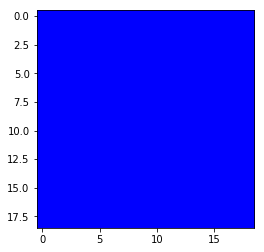

In [5]:
game.draw() 
plt.show()
for i in range(0):
    if game.game_over():
        print('Game Over')
        break
        
    result = tree_search.search()
    results.append(result)
    game.take_action(result['action'])
    
    display.clear_output(wait=True)
    print("Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
    game.draw()    
    plt.show()

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

# Model

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Activation, LeakyReLU, add
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

Using TensorFlow backend.


In [7]:
def res_block(width,inp):
    x = Conv2D(width, (3,3), padding='same')(inp)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = add([x, inp])
    x = LeakyReLU(alpha=0.3)(x)
    return BatchNormalization(axis=3)(x)

In [8]:
def down_pooling_block(width,inp):
    x = Conv2D(width, (3,3), padding='same')(inp)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(2*width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(4*width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

In [9]:
hidden_layer_count = 512

input_state= Input(shape=(shape[0],shape[1],3))
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(input_state)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)

pmx = res_block(hidden_layer_count, x)
pmx = Conv2D(1, (1,1), padding='same')(pmx)
pmx = LeakyReLU(alpha=0.3)(pmx)
pmx = Flatten()(pmx)
prob_map = Activation('softmax', name='prob_map')(pmx)

#wx = down_pooling_block(hidden_layer_count, x)
wx = res_block(hidden_layer_count, x)
wx = GlobalAveragePooling2D()(wx)
wx = Dense(hidden_layer_count)(wx)
wx = LeakyReLU(alpha=0.3)(wx)
winner = Dense(1, activation='tanh', name='winner')(wx)


model = Model(input_state, [prob_map,winner])

model.compile(
    optimizer=Nadam(), 
    loss=['categorical_crossentropy','mean_squared_error'],
    loss_weights=[1, 2]
)

In [10]:
model.load_weights('/data/trained_models/gomoku_alpha_zero_resnet_weights_v4.h5')

# Pre train with hand crafted model

In [14]:
def action_to_onehot(action):
    result = np.zeros(shape)
    result[action] = 1
    return result

def board_augmentation(inp, out):
    sym = random.choice([' ','|','\\'])
    if sym == '|':
        inp = np.flip(inp,axis=0)
        out = np.flip(out,axis=0)
    elif sym =='\\':
        inp = np.transpose(inp, axes=(1,0,2))
        out = np.transpose(out)

    k = random.randint(0,3)
    return np.rot90(inp,k=k, axes=(0,1)), np.rot90(out,k=k, axes=(0,1))
    
        

In [ ]:
game = Gomoku(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 4)

In [ ]:
batch_size = 64

for batch_index in range(0):
    batch_input = []
    batch_move_pred = []
    batch_win_pred = []

    for i in range(batch_size):
        if game.game_over():
            game.reset()

        result = tree_search.search()

        board, action = board_augmentation(game.get_state_for_current_player(), action_to_onehot(result['action']))
        
        batch_input.append(board)
        batch_move_pred.append(action.flatten())
        batch_win_pred.append(result['outcome'])

        game.take_action(result['action'])

        #display.clear_output(wait=True)
        #print(str(i) + " Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
        #game.draw()    
        #plt.show()

    losses = model.train_on_batch(np.array(batch_input), [np.array(batch_move_pred), np.array(batch_win_pred)])
    print(batch_index, losses, end="\r")

# Pre train from recorded games

In [23]:
from os import listdir
from os.path import isfile, join
import math

In [24]:
data_path = '/data/gomoku_alpha_zero/2_10'
data_files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

In [27]:
train_boards = []
train_scores = []
train_actions = []

base = np.ones(shape)
base[math.floor(shape[0]/2), math.floor(shape[1]/2)] += 1

for file in data_files:
    with open(data_path+"/"+file, 'r') as f:
        board = np.stack((np.zeros(shape), np.zeros(shape),np.copy(base)), axis=2)
        player = 0
        for line in f.readlines():
            line = line.split(',')
            
            original = np.copy(board)
            action = action_to_onehot((int(line[1]), int(line[2])))
            
            original, action = board_augmentation(original, action)
            
            train_boards.append(original)
            train_scores.append(float(line[0]))
            train_actions.append(action.flatten())
            
            board[int(line[1]), int(line[2]), player] = 1
            player = 1 - player
            
            

In [28]:
len(train_actions)

327002

In [30]:
model.fit(np.array(train_boards), [np.array(train_actions),np.array(train_scores)], shuffle=True, epochs=1, batch_size=128)

Epoch 1/1
327002/327002 [==============================] - 1814s 6ms/step - loss: 2.9435 - prob_map_loss: 2.8067 - winner_loss: 0.0684


In [1]:
#model.save('/data/trained_models/gomoku_alpha_zero_resnet_full_model_v4.h5')
#model.save_weights('/data/trained_models/gomoku_alpha_zero_resnet_weights_v4.h5')

# Reenforment learning

In [35]:
def choice2d(pmap, count = 10):
    shape = pmap.shape
    indices = np.transpose(np.indices(shape), axes=(1,2,0)).reshape((shape[0]*shape[1],2))
    choice_indices = np.random.choice(len(indices), count, p=pmap.reshape(shape[0]*shape[1]))
    return list(map(lambda x: tuple(x), indices[choice_indices].tolist()))

class LearnedGomokuModel:
    def __init__(self, model):
        self.model = model
    
    def predicted_outcome(self, game):
        pred = model.predict(np.array([game.get_state_for_current_player()]))
        return pred[1][0][0]

    def most_probable_actions(self, game, max_branching):
        return list(set(choice2d(self.get_probability_map(game), max_branching)))
    
    def get_probability_map(self, game):
        pred = model.predict(np.array([game.get_state_for_current_player()]))
        pmap = np.multiply(pred[0][0].reshape(game.get_shape()), 1-game.get_occupied())
        return pmap / np.sum(pmap) 

In [36]:
game = Gomoku(shape)
lmodel = LearnedGomokuModel(model)
tree_search = MonteCarloTreeSearch(game, LearnedGomokuModel(model), 3, 10)
results = []

Outcome: 1/0.891409  Action: (1, 12)


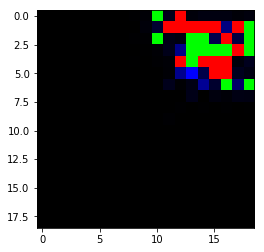

Outcome: 0.145707577467  Action: (5, 15)
Outcome: 0.270051211119  Action: (3, 13)
Outcome: 0.307166099548  Action: (5, 16)
Outcome: 0.353186011314  Action: (2, 13)
Outcome: 0.423730671406  Action: (4, 16)
Outcome: 0.474253952503  Action: (6, 16)
Outcome: 0.593947947025  Action: (1, 13)
Outcome: 0.64632743597  Action: (2, 14)
Outcome: 0.637798905373  Action: (4, 15)
Outcome: 0.747975349426  Action: (3, 14)
Outcome: 0.741117835045  Action: (1, 11)
Outcome: 0.815999269485  Action: (3, 18)
Outcome: 0.76479434967  Action: (1, 15)
Outcome: 0.837856888771  Action: (2, 18)
Outcome: 0.788702130318  Action: (1, 17)
Outcome: 0.862542450428  Action: (3, 15)
Outcome: 0.799893140793  Action: (4, 12)
Outcome: 0.878341436386  Action: (2, 10)
Outcome: 0.854198634624  Action: (4, 14)
Outcome: 0.851556241512  Action: (4, 13)
Outcome: 0.829960227013  Action: (3, 17)
Outcome: 0.892325401306  Action: (0, 10)
Outcome: 0.844632327557  Action: (0, 12)
Outcome: 0.881548285484  Action: (1, 18)
Outcome: 1  Action

In [37]:
while not game.game_over():
    result = tree_search.search()
    results.append(result)
    game.take_action(result['action'])
    predicted_outcome = lmodel.predicted_outcome(game)
    
    display.clear_output(wait=True)
    print("Outcome: " + str(result['outcome']) + "/" + str(predicted_outcome) + "  Action: " + str(result['action']))
    pmap = lmodel.get_probability_map(game)
    board = game.get_state()
    plt.imshow(np.stack([board[:,:,0], board[:,:,1], pmap/np.max(pmap)], axis = 2))
    plt.show()
    

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

-1.0


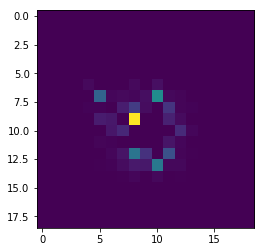

In [64]:
lmodel = LearnedGomokuModel(model)
#lmodel = HandCraftedGomokuModel()
print(lmodel.predicted_outcome(game))
plt.imshow(lmodel.get_probability_map(game))